In [1]:
import nexradaws
import tempfile
import os
import shutil
import pyart
from matplotlib import pyplot as plt
from netCDF4 import num2date
import numpy as np

from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress
#import six


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
templocation = tempfile.mkdtemp()
conn = nexradaws.NexradAwsInterface()
scans = conn.get_avail_scans('2011', '05', '20','KTLX')


In [3]:
scans[10:20]

[<AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_004418_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_004832_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_005247_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_005703_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_010118_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_010532_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_010947_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_011401_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_011817_V03.gz>,
 <AwsNexradFile object - 2011/05/20/KTLX/KTLX20110520_012233_V03.gz>]

In [4]:
tscan = scans[10]

In [5]:
lcn = templocation
localfiles = conn.download(tscan,lcn)

Downloaded KTLX20110520_004418_V03.gz
1 out of 1 files downloaded...0 errors


In [6]:
radar = pyart.io.read(localfiles.success[0].filepath)

/srv/conda/envs/notebook/lib/python3.6/site-packages/pyart/graph/radarmapdisplay.py:268: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes.
  UserWarning)


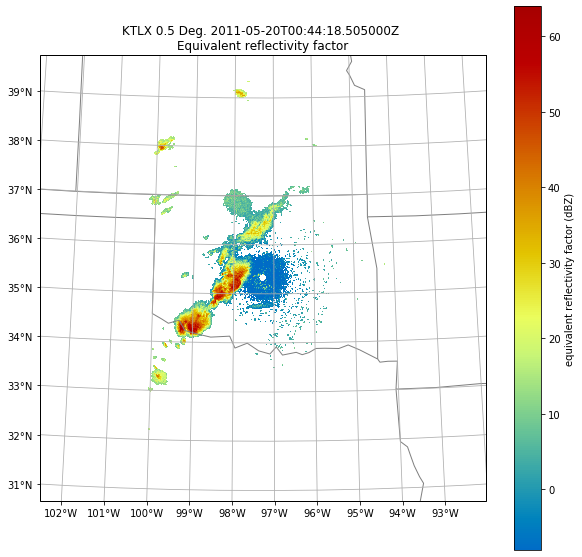

In [7]:
myf = plt.figure(figsize=[10,10])
myd = pyart.graph.RadarMapDisplay(radar)
myd.plot_ppi_map('reflectivity', 0, vmin=-8, vmax=64)

In [8]:

# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
cluster = KubeCluster(n_workers=10)


In [9]:
cluster

In [10]:

# Attach Dask to the cluster
client = Client(cluster)

In [27]:
def simple_sum(scan_number):
    templocation = tempfile.mkdtemp()
    conn = nexradaws.NexradAwsInterface()
    scans = conn.get_avail_scans('2011', '05', '20','KTLX')
    tscan = scans[scan_number]
    localfiles = conn.download(tscan,templocation)
    this_dataset = pyart.io.read(localfiles.success[0].filepath)
    fp = 1
    time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
    tgates = float(this_dataset.ngates*this_dataset.nrays)
    zdat = this_dataset.fields['reflectivity']['data']
    fp = 2
    z0 = float(len(np.where(zdat > 0.)[0]))/tgates
    z10 = float(len(np.where(zdat > 10.)[0]))/tgates
    z40 = float(len(np.where(zdat > 40.)[0]))/tgates
    del this_dataset
    rv = (time_start, z0, z10, z40)
    return rv



In [28]:
simple_sum(1)

Downloaded KTLX20110520_000559_V03.gz
1 out of 1 files downloaded...0 errors


(datetime.datetime(2011, 5, 20, 0, 5, 59, 244000),
 0.07775437472311879,
 0.058384556357192585,
 0.005890054426935004)

In [29]:
client

Client Scheduler: tcp://10.49.128.4:39117 Dashboard: /user/openradar-ams-o-urce-radar-2019-bdwiw1o7/proxy/8787/status,Cluster Workers: 10 Cores: 20 Memory: 70.00 GB


In [30]:
future = client.map(simple_sum, range(len(scans)))


In [31]:
progress(future)

VBox()

In [32]:
my_data = client.gather(future)

In [33]:
times = np.array([tpl[0] for tpl in my_data])
z0 = np.array([tpl[1] for tpl in my_data])
z10 = np.array([tpl[2] for tpl in my_data])
z40 = np.array([tpl[3] for tpl in my_data])


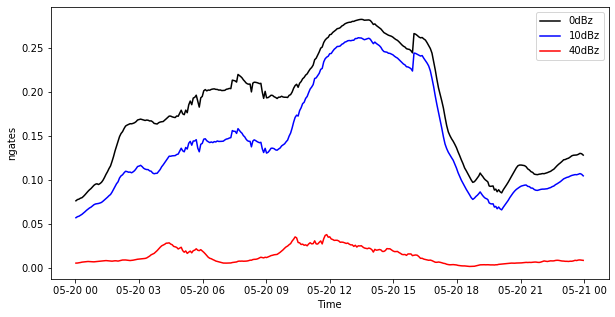

In [34]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(times, z0, '-k', label='0dBz')
plt.plot(times, z10, '-b', label='10dBz')
plt.plot(times, z40, '-r', label='40dBz')
plt.ylabel('ngates')
plt.xlabel('Time')
plt.legend()